# Generative Models

<figure>
    <img src="https://drive.google.com/uc?export=view&id=1UjunyOkHxHewQ51X75Edq8VYlQshNyRr" alt="Picture" style="display: block; margin: 0 auto;" />
    <figcaption style="text-align: center;"><strong>Fig. 1: Face Generation using GAN. Source: <a href="https://www.eff.org/files/2018/02/20/malicious_ai_report_final.pdf">https://www.eff.org/files/2018/02/20/malicious_ai_report_final.pdf</a></strong></figcaption>
</figure>



In [ ]:
#@title Imports

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import matplotlib.pyplot as plt

import tensorflow as tf

from torch.utils.data import DataLoader

In [ ]:
#@title Auxiliary Functions

class Reshape(nn.Module):
    def __init__(self, *args):
        super(Reshape, self).__init__()
        self.shape = args

    def forward(self, x):
        return x.view(x.size(0), *self.shape)


def generate_noise(batch_size, noise_dim):
    return torch.randn(batch_size, noise_dim, 1, 1).to(device)

def generate_images(generator):
    noise = generate_noise(25, 100)

    generator.eval()
    generated_images = generator(noise)
    generated_images = generated_images.view(25, 28, 28).detach().cpu().numpy()

    fig, axes = plt.subplots(5, 5, figsize=(10, 10))
    for i, ax in enumerate(axes.flat):
        ax.imshow(generated_images[i], cmap='gray')
        ax.axis('off')

    plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

In [ ]:
#@title Dataset

transform = transforms.Compose([
    transforms.ToTensor(),
])

trainset = datasets.MNIST(root='MNIST_data/', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='MNIST_data/', train=False, download=True, transform=transform)

#trainset = Subset(trainset, range(0, len(trainset)//10))
#testset = Subset(testset, range(0, len(testset)//10))

trainloader = DataLoader(trainset, batch_size=32, shuffle=True)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.4MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.94MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.38MB/s]


# Variational Auto-Encoders

> #### **Exercise:** Using the MNIST dataset train a variational autoencoder. To do this you must implement the encoder, the decoder, the reparametrize trick, and the loss function. Then, show the generated latent space. Finally, analyze the obtained results.

### Encoder

|Layer (Type)| Output Shape |
|-|-|
| Input Layer | (28, 28, 1) |
| Conv2D | (28, 28, 32) |
| Conv2D | (14, 14, 32) |
| Conv2D | (14, 14, 64) |
| Flatten | 14x14x64 |
| Dense $(z \ \mu)$  | Latent Dim |
| Dense $(z \ log \ var)$ | Latent Dim |
| Sampling($z$) | Latent Dim |

Activation Functions: ReLU


In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.latent_dim = 5

        # Convolutional Layers
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)

        # Fully connected layers for the latent space
        self.fc1 = nn.Linear(14 * 14 * 64, self.latent_dim)  # mu
        self.fc2 = nn.Linear(14 * 14 * 64, self.latent_dim)  # log_var

        self.flatten = nn.Flatten()

    # Reparametrization Trick (Sampling)
    def sampling(self, mu, log_var):
        std = torch.exp(0.5 * log_var)

        # eps -> mean = 0 and std = 1.0
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        # Apply convolutional layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))

        # Flatten the output
        x = self.flatten(x)

        # Get latent parameters and sample
        mu = self.fc1(x)
        log_var = self.fc2(x)
        z = self.sampling(mu, log_var)

        return z, mu, log_var

### Decoder

| Layer (Type)                | Output Shape |
|-----------------------------|--------------|
| Dense        | (Latent Dim, 14x14x64)    |
| Reshape                     | (64, 14, 14)   |
| ConvTranspose2D | (32, 28, 28) |
| ConvTranspose2D | (28, 28, 1) |
| ConvTranspose2D | (28, 28, 1)  |

Activation Functions:
- ReLU and Sigmoid for the output layer

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.latent_dim = 5

        # Fully Connected Layer
        self.fc = nn.Linear(self.latent_dim, 14*14*64)

        # Convolutional Transpose Layers
        self.conv2d_transpose1 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,
            kernel_size=3,
            stride=2,
            padding=1,
            output_padding=1
        )

        self.conv2d_transpose2 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.conv2d_transpose3 = nn.ConvTranspose2d(
            in_channels=1,
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=1
        )


    def forward(self, x):
        # Apply the fully connected layer
        x = self.fc(x)

        # Reshape to [batch_size, 64, 14, 14]
        x = x.view(-1, 64, 14, 14)

        # Apply transposed convolution layers with activations
        x = F.relu(self.conv2d_transpose1(x))
        x = F.relu(self.conv2d_transpose2(x))
        x = torch.sigmoid(self.conv2d_transpose3(x))

        return x

### VAE Model

In [ ]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    def loss(self, x, x_hat, mu, log_var):
      KL = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

      reconstruction = F.mse_loss(x_hat, x, reduction='sum')

      return KL + reconstruction

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(model, trainloader, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for i, (x, _) in enumerate(trainloader):
            x = x.to(device)
            x_hat, mu, log_var = model(x)
            loss = model.loss(x, x_hat, mu, log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f'\rEpoch {epoch}, Iteration {i}, Loss: {loss.item():.4f}', end="")

train(model, trainloader, optimizer, epochs=5)

Epoch 4, Iteration 1800, Loss: 1150.2927

### Latent Space

In [ ]:
# Plot latent space with labels
import numpy as np
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

model.eval()
z = []
labels = []
with torch.no_grad():
    for x, y in testloader:
        x = x.to(device)
        z_, _, _ = model.encoder(x)
        z.append(z_.cpu().numpy())
        labels.append(y.numpy())

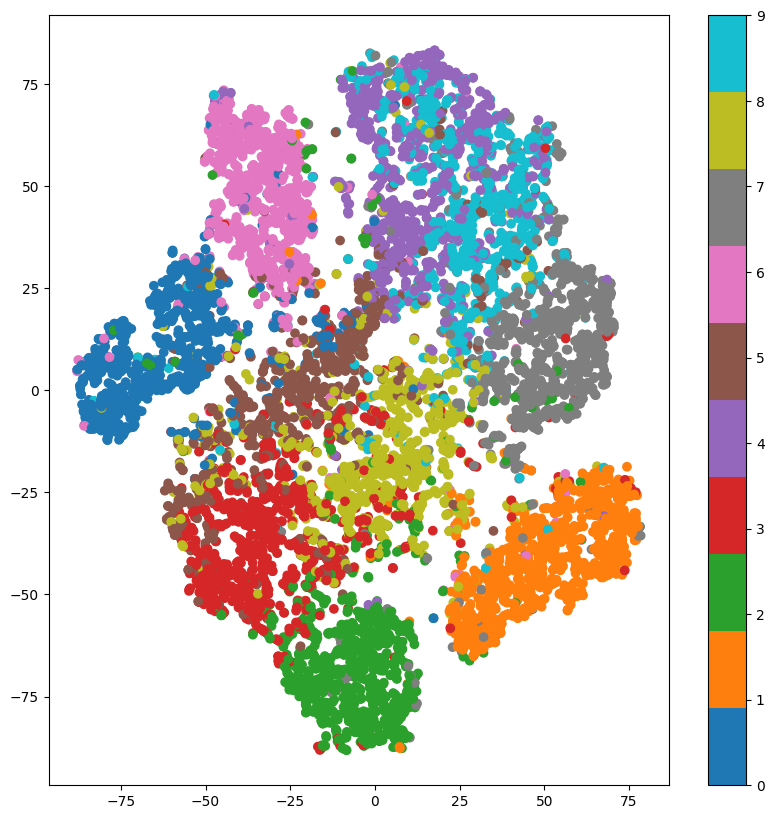

In [ ]:
# MDS
z = np.concatenate(z)
#mds = MDS(n_components=2)
tsne = TSNE(n_components=2)
z = tsne.fit_transform(z)

labels = np.concatenate(labels)
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

### Latent Space (Numbers)

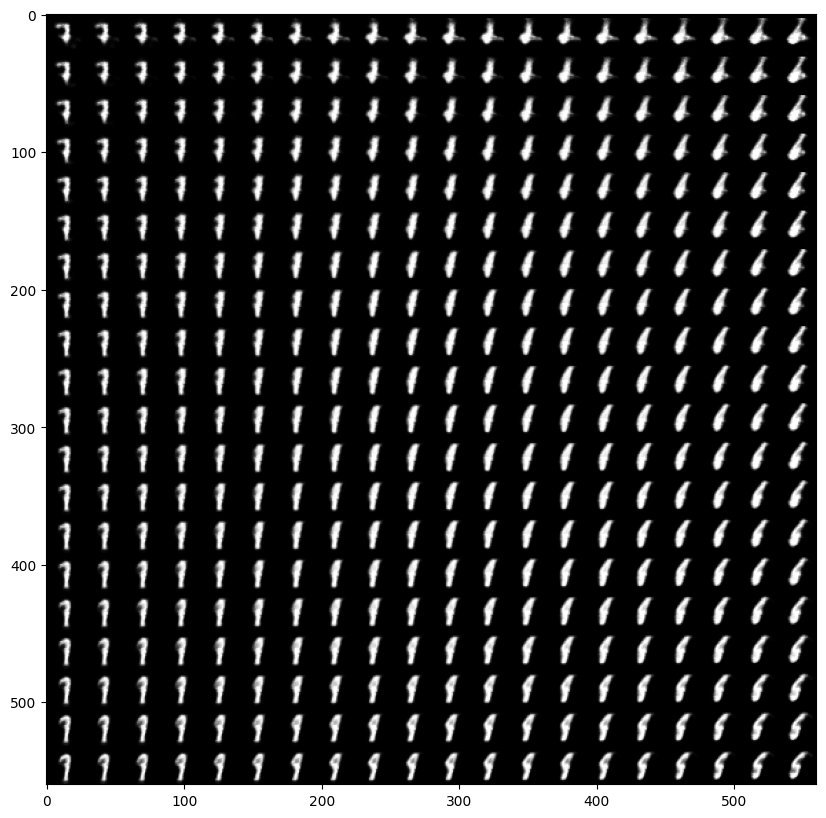

In [ ]:
from scipy.stats import norm
n = 20  # figure with 20x20 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# Construct grid of latent variable values
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

model.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            # with 5 latent vaariables, we can only visualize 2 dimensions
            # so we fix the other dimensions to 1
            z_sample = np.array([[xi, yi, 1, 1, 1]])
            z_sample = np.tile(z_sample, 32).reshape(32, 5)
            z_sample = torch.tensor(z_sample, dtype=torch.float32).to(device)
            x_decoded = model.decoder(z_sample)
            x_decoded = x_decoded.cpu().numpy()
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='gray')
plt.show()

### Reconstructions

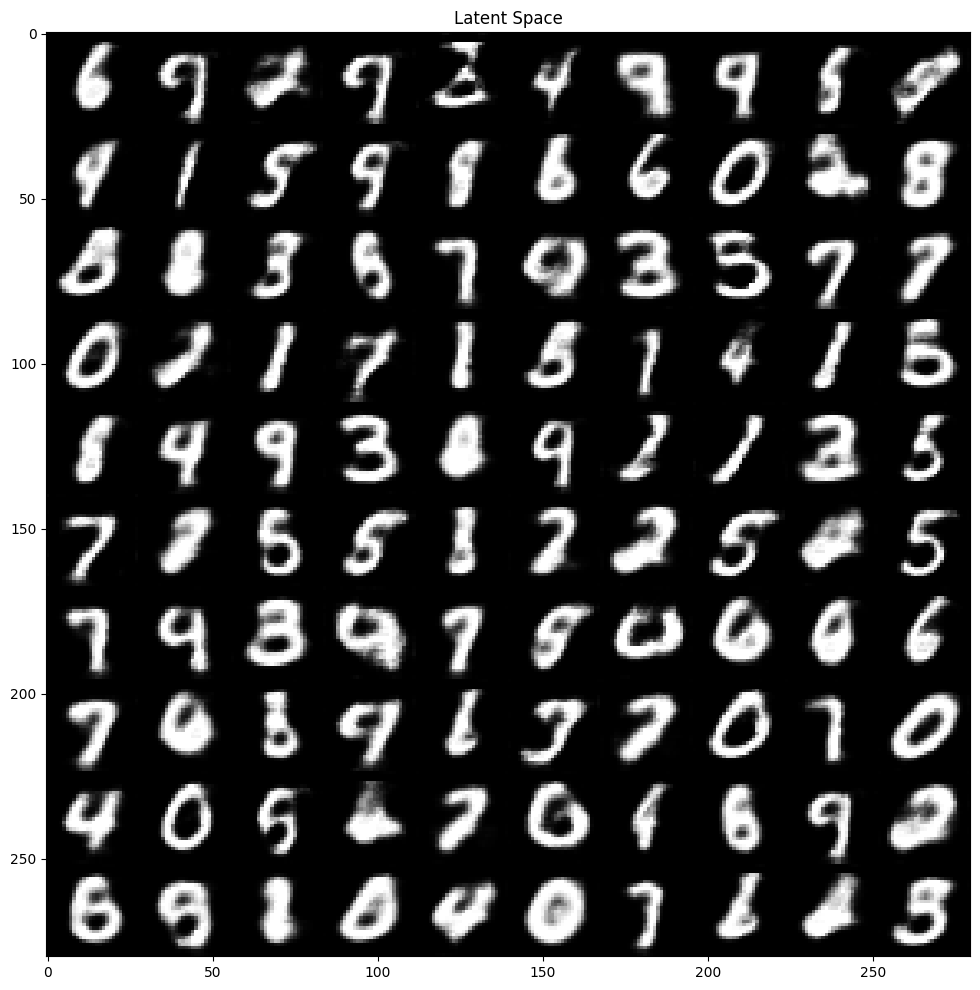

In [ ]:

# Grid with numbers sampled from the latent space
import numpy as np
def plot_images(rows, cols, images, title):
    '''Displays images in a grid.'''
    images = images.reshape(rows, cols, 28, 28)  # Reshape images array
    grid = np.zeros(shape=(rows*28, cols*28))
    for i in range(rows):
        for j in range(cols):
            grid[i*28:(i+1)*28, j*28:(j+1)*28] = images[i, j]


    plt.figure(figsize=(12,12))
    plt.imshow(grid, cmap='gray')
    plt.title(title)
    plt.show()

model.eval()
n = 10
# Use normal distribution to sample from latent space
latent_space = torch.randn(n*n, model.encoder.latent_dim).to(device)
images = model.decoder(latent_space).view(-1, 1, 28, 28).cpu().detach().numpy()
plot_images(n, n, images, 'Latent Space')

> ### **Exercise:**  Adapt the loss function to use the hyperparameter $\beta$. Then, check how the modification of this parameter influences the generation of the latent space.

https://openreview.net/pdf?id=Sy2fzU9gl

In [ ]:
class BetaVAE(nn.Module):
    def __init__(self, beta=1.0):
        super(BetaVAE, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
        self.beta = beta  # Hyperparameter to control KL divergence weight

    def forward(self, x):
        z, mu, log_var = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat, mu, log_var

    def loss(self, x, x_hat, mu, log_var):
        # KL Divergence
        KL = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

        # Reconstruction loss (using binary cross entropy)
        reconstruction = F.binary_cross_entropy(x_hat, x, reduction='sum')

        # Apply beta weight to the KL divergence term
        return reconstruction + self.beta * KL

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = BetaVAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

def train(model, trainloader, optimizer, epochs=5):
    model.train()
    for epoch in range(epochs):
        for i, (x, _) in enumerate(trainloader):
            x = x.to(device)
            x_hat, mu, log_var = model(x)
            loss = model.loss(x, x_hat, mu, log_var)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if i % 100 == 0:
                print(f'\rEpoch {epoch}, Iteration {i}, Loss: {loss.item():.4f}', end="")

train(model, trainloader, optimizer, epochs=5)

Epoch 4, Iteration 1800, Loss: 4380.4292

In [ ]:
# Plot latent space with labels
import numpy as np
from sklearn.manifold import TSNE
from sklearn.manifold import MDS

model.eval()
z = []
labels = []
with torch.no_grad():
    for x, y in testloader:
        x = x.to(device)
        z_, _, _ = model.encoder(x)
        z.append(z_.cpu().numpy())
        labels.append(y.numpy())

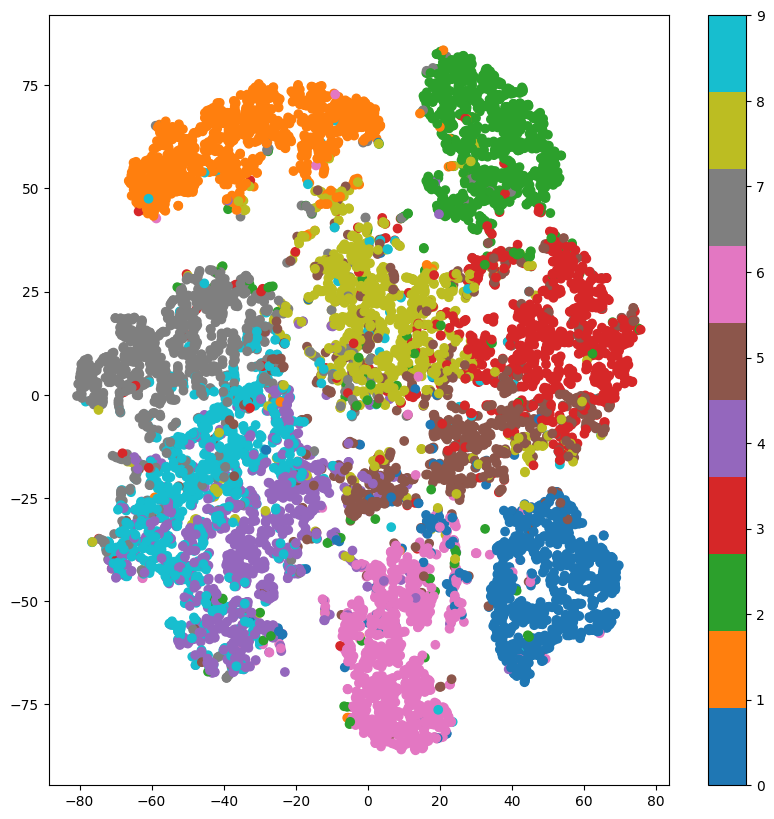

In [ ]:
# MDS
z = np.concatenate(z)
#mds = MDS(n_components=2)
tsne = TSNE(n_components=2)
z = tsne.fit_transform(z)

labels = np.concatenate(labels)
plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], c=labels, cmap='tab10')
plt.colorbar()
plt.show()

We can see that the distribution has change a lot, in the previous graph, for example, the orange ones ( label 1) where allocated in the left bottom corner , otherwise now they are in the top right, so the distribution of the latent space has changed because of the Beta parameter

# Generative Adversarial Networks

> ### **Exercise:** Implement the Generator and the Discriminator. Then generate some samples and plot the loss of the generator and discriminator.

### Generator

---
   |Layer (type)     |          Output Shape |
   |--|--|
   |ConvTranspose2d      |     [128, 7, 7]    |
   |ConvTranspose2d      |     [128, 7, 7]    |
   |           ReLU      |         |
   |ConvTranspose2d      |     [64, 14, 14]    |
   |ConvTranspose2d      |     [64, 14, 14]    |
   |           ReLU      |         |
   |ConvTranspose2d      |     [1, 28, 28]    |
   |ConvTranspose2d      |     [1, 28, 28]    |
   |           Tanh      |         |
   
   ---


In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # First pair of transposed convolution layers (to 7x7)
        self.conv2d_transpose1 = nn.ConvTranspose2d(
            in_channels=100,    # Assuming 100-dimensional latent space
            out_channels=128,
            kernel_size=7,
            stride=1,
            padding=0
        )

        self.conv2d_transpose2 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=1
        )

        # Second pair of transposed convolution layers (to 14x14)
        self.conv2d_transpose3 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.conv2d_transpose4 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1
        )

        # Third pair of transposed convolution layers (to 28x28)
        self.conv2d_transpose5 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=1,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.conv2d_transpose6 = nn.ConvTranspose2d(
            in_channels=1,
            out_channels=1,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.generator = nn.Sequential(
            self.conv2d_transpose1,
            self.conv2d_transpose2,
            nn.ReLU(),
            self.conv2d_transpose3,
            self.conv2d_transpose4,
            nn.ReLU(),
            self.conv2d_transpose5,
            self.conv2d_transpose6,
            nn.Tanh()
        )

    def forward(self, x):
        return self.generator(x)

### Discriminator

---
| Layer (type)      |         Output Shape  |
|--|--|
|      Conv2d        |   [64, 14, 14]   |
|      Conv2d        |   [64, 14, 14]   |
|   ReLU        |      |
|      Conv2d        |   [128, 7, 7]   |
|      Conv2d        |   [128, 7, 7]   |
|   ReLU        |      |
|      Conv2d        |   [1, 1, 1]   |
|     Sigmoid        |      |
---

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # First pair of convolution layers (28x28 -> 14x14)
        self.conv2d1 = nn.Conv2d(
            in_channels=1,      # 1 channel for grayscale MNIST
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.conv2d2 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.conv2d3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.conv2d4 = nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.conv2d5 = nn.Conv2d(
            in_channels=128,
            out_channels=1,
            kernel_size=7,
            stride=1,
            padding=0
        )

        self.discriminator = nn.Sequential(
            self.conv2d1,
            self.conv2d2,
            nn.ReLU(),
            self.conv2d3,
            self.conv2d4,
            nn.ReLU(),
            self.conv2d5,
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.discriminator(x)

### Training

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = Generator().to(device)
discriminator = Discriminator().to(device)

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00005)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

loss_generator_iters = []
loss_discriminator_iters = []

def train():
    # Real and Fake labels
    real_label, fake_label = 1, 0

    # Loss function
    criterion = nn.BCELoss()

    for epoch in range(5):

        for i, (real_images, _) in enumerate(trainloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            real_labels = torch.full((batch_size, 1,1,1), real_label, dtype=torch.float, device=device)
            fake_labels = torch.full((batch_size, 1,1,1), fake_label, dtype=torch.float, device=device)

            # Train the discriminator
            discriminator.zero_grad()
            output = discriminator(real_images)
            loss_real = criterion(output, real_labels)
            loss_real.backward()


            # Generate fake images
            noise = generate_noise(batch_size, 100)
            fake_images = generator(noise)
            output = discriminator(fake_images.detach())
            loss_fake = criterion(output, fake_labels)
            loss_fake.backward()


            discriminator_optimizer.step()

            # Train the generator
            generator.zero_grad()
            output = discriminator(fake_images)
            loss_generator = criterion(output, real_labels)
            loss_generator.backward()

            generator_optimizer.step()

            print(f'\rEpoch [{epoch}], Step [{i}/{len(trainloader)}], Loss D: {loss_real + loss_fake}, Loss G: {loss_generator}', end='')

        # Save images for plot on each epoch
        generate_images(generator)

        # Save losses
        loss_generator_iters.append(loss_generator.item())
        loss_discriminator_iters.append(loss_real.item() + loss_fake.item())

Epoch [0], Step [1874/1875], Loss D: 0.3044031262397766, Loss G: 3.675752639770508

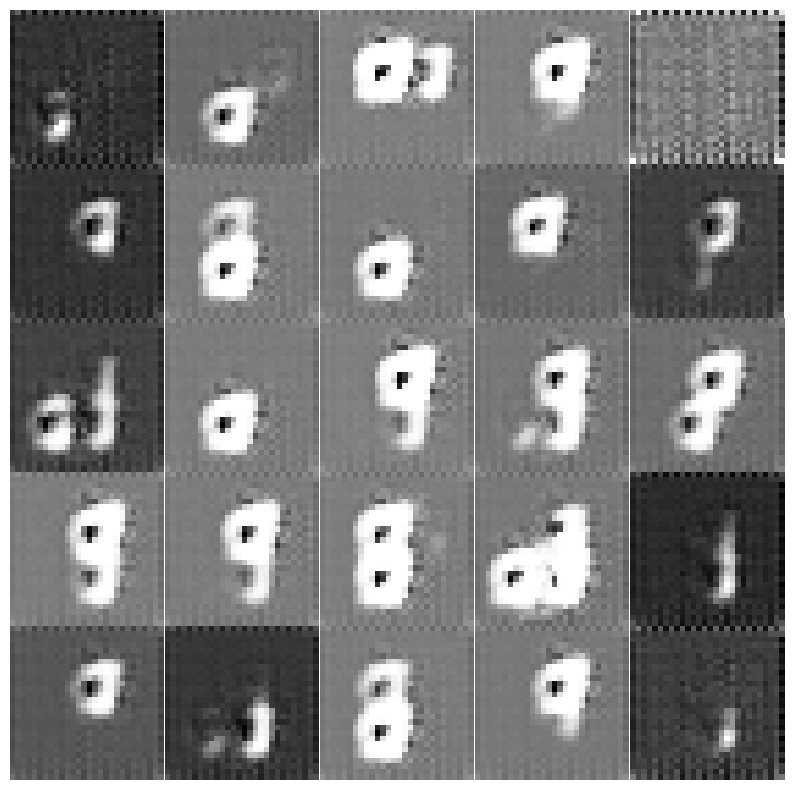

Epoch [1], Step [1874/1875], Loss D: 0.051743850111961365, Loss G: 4.364678859710693

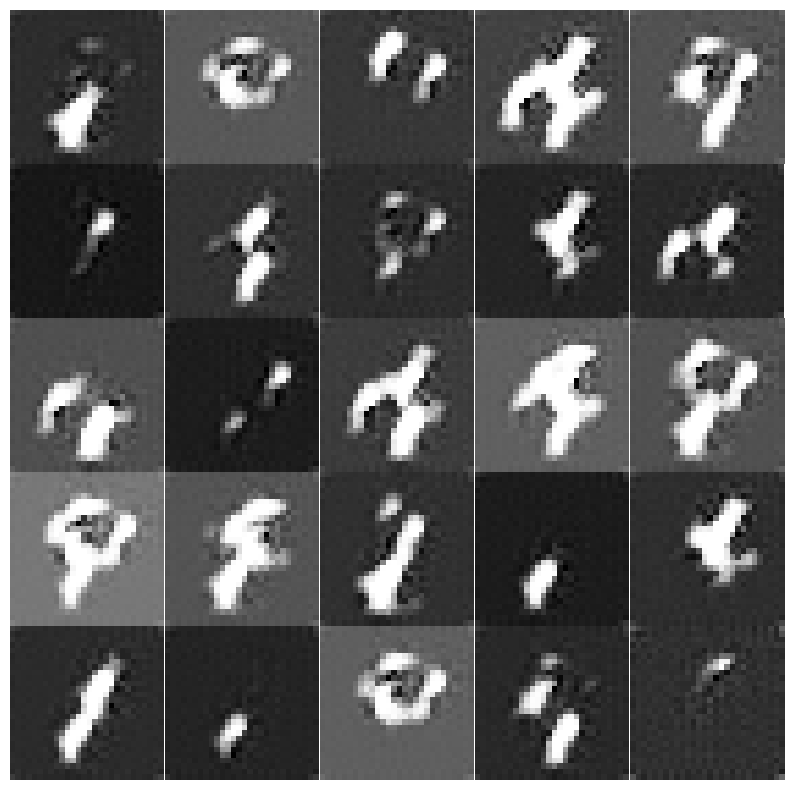

Epoch [2], Step [1874/1875], Loss D: 0.03771987557411194, Loss G: 4.207094192504883

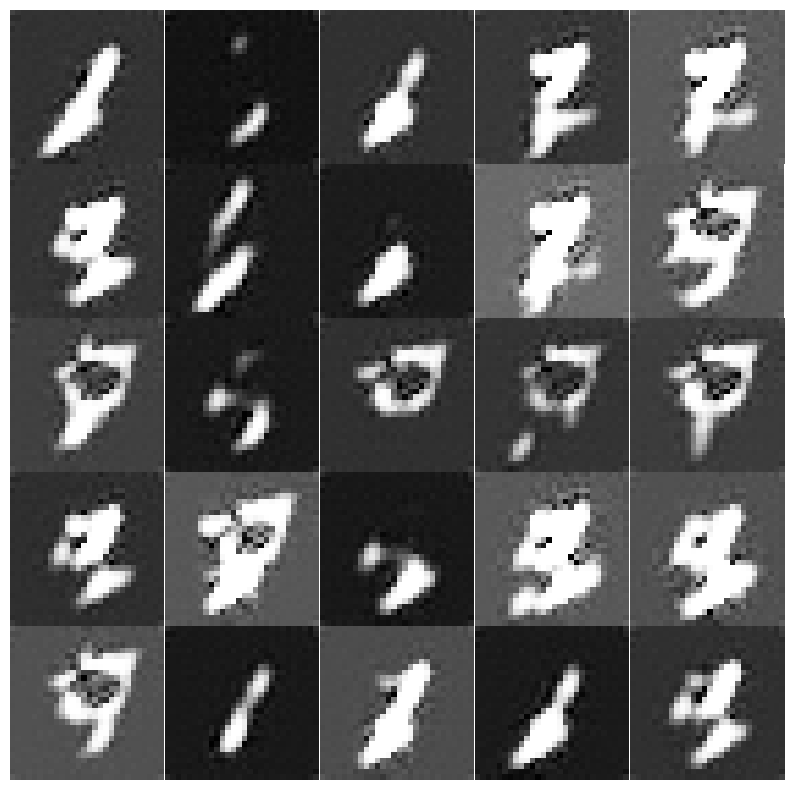

Epoch [3], Step [1874/1875], Loss D: 0.07574621587991714, Loss G: 7.277189254760742

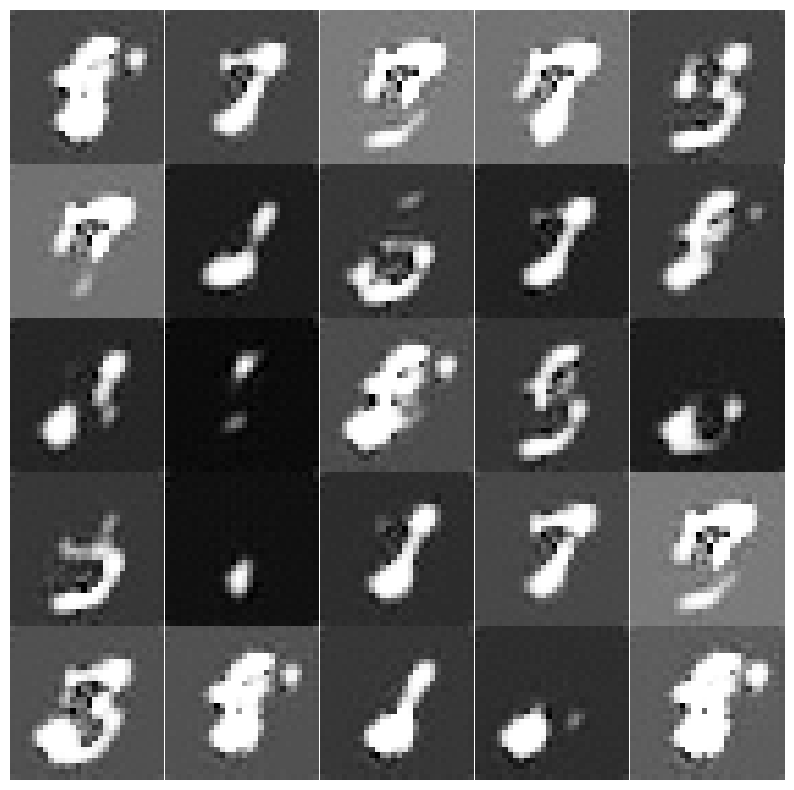

Epoch [4], Step [1874/1875], Loss D: 0.0472462922334671, Loss G: 5.074123382568359

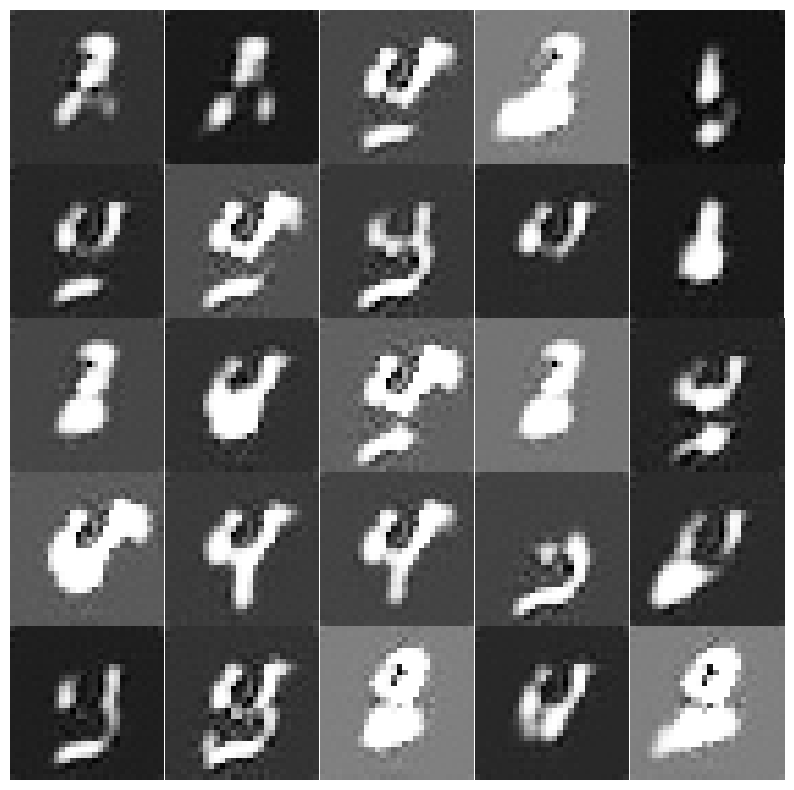

In [ ]:
%matplotlib inline
train()

> ### **Exercise:** Improve the Generator and the Discriminator (you can add some Batch Normalization layers, dropout, etc). Then, generate new samples and compare the results.

In [ ]:
class ImprovedGenerator(nn.Module):
    def __init__(self):
        super(ImprovedGenerator, self).__init__()

        # First pair of transposed convolution layers (to 7x7)
        self.conv2d_transpose1 = nn.ConvTranspose2d(
            in_channels=100,
            out_channels=128,
            kernel_size=7,
            stride=1,
            padding=0
        )
        self.bn1 = nn.BatchNorm2d(128)

        self.conv2d_transpose2 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(128)

        # Second pair of transposed convolution layers (to 14x14)
        self.conv2d_transpose3 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.bn3 = nn.BatchNorm2d(64)

        self.conv2d_transpose4 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn4 = nn.BatchNorm2d(64)

        # Third pair of transposed convolution layers (to 28x28)
        self.conv2d_transpose5 = nn.ConvTranspose2d(
            in_channels=64,
            out_channels=32,  # Increased channels before final output
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.bn5 = nn.BatchNorm2d(32)

        self.conv2d_transpose6 = nn.ConvTranspose2d(
            in_channels=32,
            out_channels=1,   # Output 1 channel
            kernel_size=3,
            stride=1,
            padding=1
        )

        self.dropout = nn.Dropout(0.3)

        # Using LeakyReLU instead of ReLU for better gradient flow
        self.leaky_relu = nn.LeakyReLU(0.2)

    def forward(self, x):
        # First block
        x = self.conv2d_transpose1(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)

        x = self.conv2d_transpose2(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        # Second block
        x = self.conv2d_transpose3(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)

        x = self.conv2d_transpose4(x)
        x = self.bn4(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        # Third block
        x = self.conv2d_transpose5(x)
        x = self.bn5(x)
        x = self.leaky_relu(x)

        x = self.conv2d_transpose6(x)
        x = torch.tanh(x)

        return x

In [ ]:
class ImprovedDiscriminator(nn.Module):
    def __init__(self):
        super(ImprovedDiscriminator, self).__init__()

        # First pair of convolution layers (28x28 -> 14x14)
        self.conv2d1 = nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=4,
            stride=2,
            padding=1
        )

        self.conv2d2 = nn.Conv2d(
            in_channels=64,
            out_channels=64,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn1 = nn.BatchNorm2d(64)

        # Second pair of convolution layers (14x14 -> 7x7)
        self.conv2d3 = nn.Conv2d(
            in_channels=64,
            out_channels=128,
            kernel_size=4,
            stride=2,
            padding=1
        )
        self.bn2 = nn.BatchNorm2d(128)

        self.conv2d4 = nn.Conv2d(
            in_channels=128,
            out_channels=128,
            kernel_size=3,
            stride=1,
            padding=1
        )
        self.bn3 = nn.BatchNorm2d(128)

        # Final convolution layer (7x7 -> 1x1)
        self.conv2d5 = nn.Conv2d(
            in_channels=128,
            out_channels=1,
            kernel_size=7,
            stride=1,
            padding=0
        )

        self.dropout = nn.Dropout(0.3)
        self.leaky_relu = nn.LeakyReLU(0.2)  # LeakyReLU for better gradient flow

    def forward(self, x):
        # First block
        x = self.conv2d1(x)
        x = self.leaky_relu(x)

        x = self.conv2d2(x)
        x = self.bn1(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        # Second block
        x = self.conv2d3(x)
        x = self.bn2(x)
        x = self.leaky_relu(x)

        x = self.conv2d4(x)
        x = self.bn3(x)
        x = self.leaky_relu(x)
        x = self.dropout(x)

        # Output layer
        x = self.conv2d5(x)
        x = torch.sigmoid(x)

        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

generator = ImprovedGenerator().to(device)
discriminator = ImprovedDiscriminator().to(device)

generator_optimizer = torch.optim.Adam(generator.parameters(), lr=0.00005)
discriminator_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.00005)

loss_generator_iters = []
loss_discriminator_iters = []

def train():
    # Real and Fake labels
    real_label, fake_label = 1, 0

    # Loss function
    criterion = nn.BCELoss()

    for epoch in range(5):

        for i, (real_images, _) in enumerate(trainloader):
            batch_size = real_images.size(0)
            real_images = real_images.to(device)
            real_labels = torch.full((batch_size, 1,1,1), real_label, dtype=torch.float, device=device)
            fake_labels = torch.full((batch_size, 1,1,1), fake_label, dtype=torch.float, device=device)

            # Train the discriminator
            discriminator.zero_grad()
            output = discriminator(real_images)
            loss_real = criterion(output, real_labels)
            loss_real.backward()


            # Generate fake images
            noise = generate_noise(batch_size, 100)
            fake_images = generator(noise)
            output = discriminator(fake_images.detach())
            loss_fake = criterion(output, fake_labels)
            loss_fake.backward()


            discriminator_optimizer.step()

            # Train the generator
            generator.zero_grad()
            output = discriminator(fake_images)
            loss_generator = criterion(output, real_labels)
            loss_generator.backward()

            generator_optimizer.step()

            print(f'\rEpoch [{epoch}], Step [{i}/{len(trainloader)}], Loss D: {loss_real + loss_fake}, Loss G: {loss_generator}', end='')

        # Save images for plot on each epoch
        generate_images(generator)

        # Save losses
        loss_generator_iters.append(loss_generator.item())
        loss_discriminator_iters.append(loss_real.item() + loss_fake.item())

Epoch [0], Step [1874/1875], Loss D: 0.021991463378071785, Loss G: 7.554570198059082

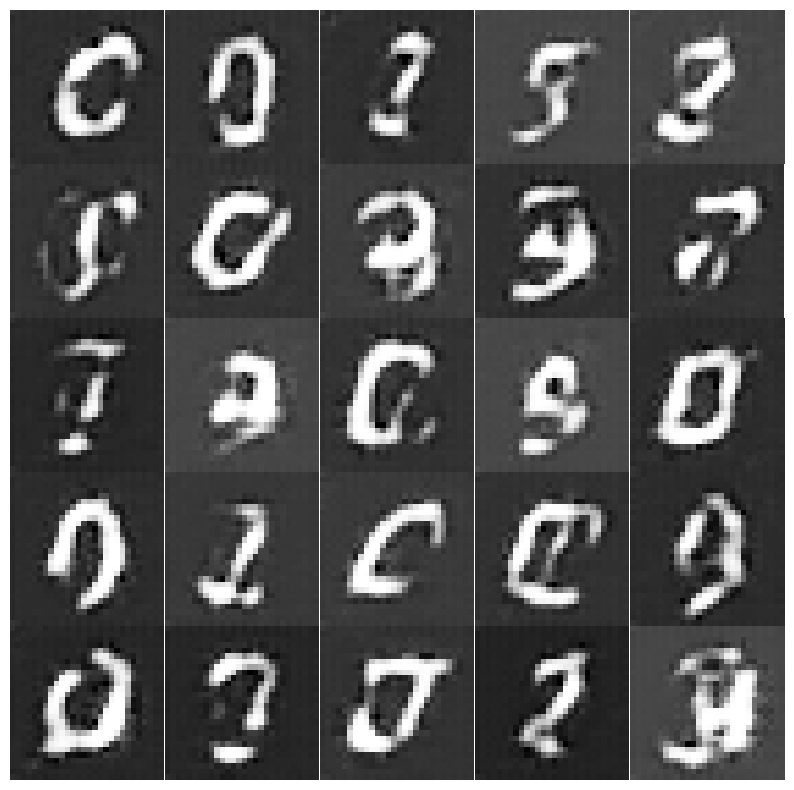

Epoch [1], Step [1874/1875], Loss D: 0.2683708071708679, Loss G: 3.710470676422119

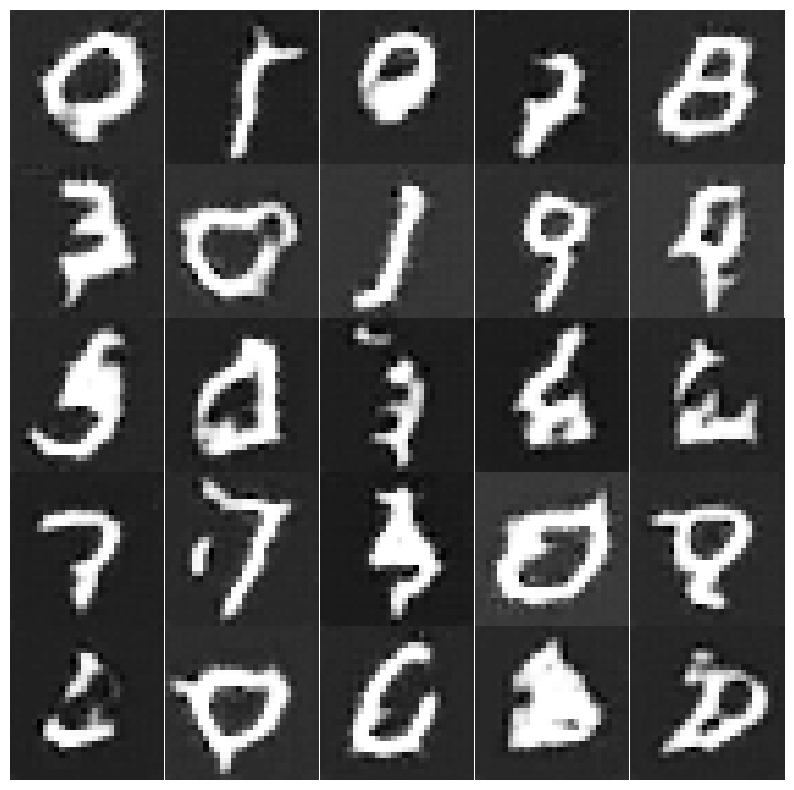

Epoch [2], Step [1874/1875], Loss D: 0.5160967111587524, Loss G: 2.594248056411743

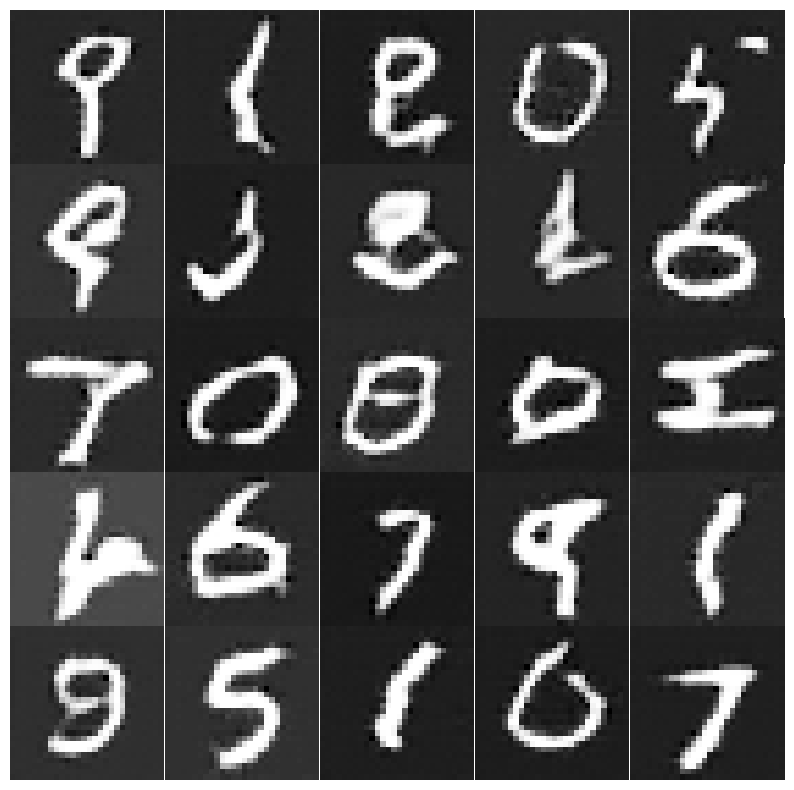

Epoch [3], Step [1874/1875], Loss D: 0.3907163143157959, Loss G: 3.5459163188934326

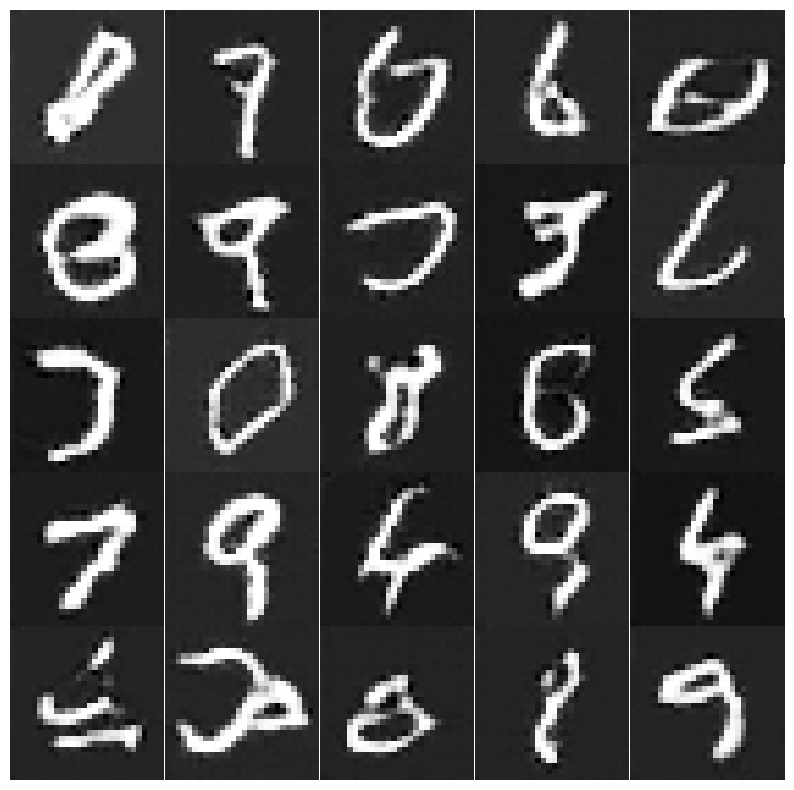

Epoch [4], Step [1874/1875], Loss D: 1.0865660905838013, Loss G: 1.2188023328781128

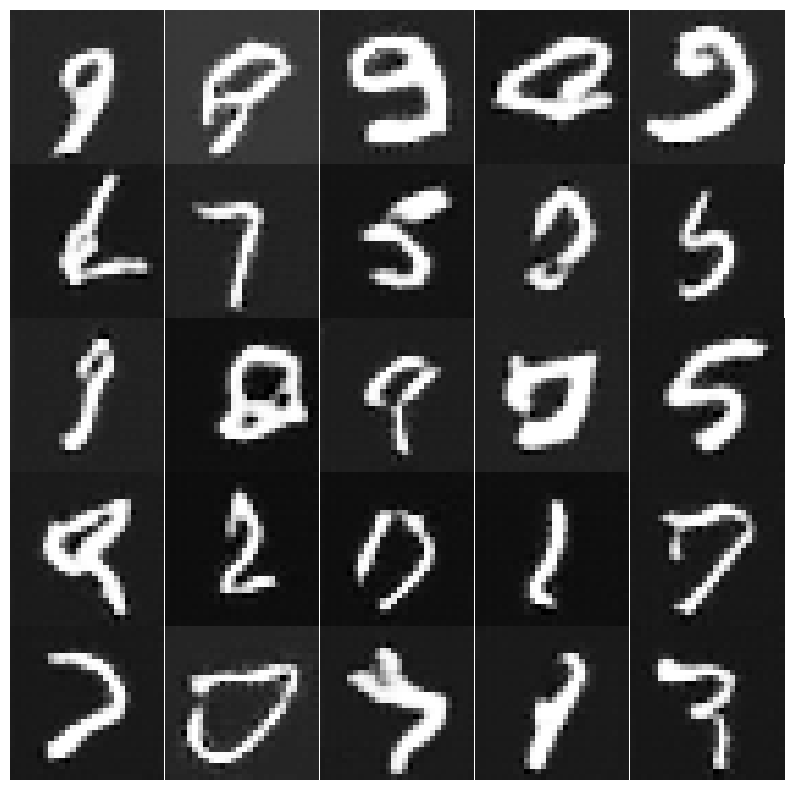

In [ ]:
%matplotlib inline
train()

The first result (D: 1.09, G: 1.22) represents better GAN training than the second (D: 0.05, G: 5.07). The similar loss values in the first case indicate a balanced adversarial relationship where both networks effectively challenge each other. This balance suggests the generator is creating convincing images while the discriminator maintains appropriate skepticism. When losses are too far apart, as in the first case, it often indicates one network dominating the other, which can lead to poor image quality or training instability.

# Diffusion Networks

Reference: [Colab](https://colab.research.google.com/github/st-howard/blog-notebooks/blob/main/MNIST-Diffusion/Diffusion%20Digits%20-%20Generating%20MNIST%20Digits%20from%20noise%20with%20HuggingFace%20Diffusers.ipynb#scrollTo=a1a0807f)

In [ ]:
%%capture
!pip install diffusers[training]==0.2.3

In [ ]:
# Imports

# Pytorch
import torch
import torchvision

# HuggingFace
import datasets
import diffusers
import accelerate

# Training and Visualization
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import os
import PIL
from torch.utils.data import DataLoader, Subset

In [ ]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size=32 #Resize the digits to be a power of two
    train_batch_size = 32
    eval_batch_size = 32
    num_epochs = 5
    gradient_accumulation_steps = 1
    learning_rate = 1e-4
    lr_warmpup_steps = 500
    mixed_precision = 'fp16'
    seed = 0

config = TrainingConfig()

mnist_dataset = datasets.load_dataset('mnist', split='train')

def transform(dataset):
    preprocess = torchvision.transforms.Compose(
        [
            torchvision.transforms.Resize(
                (config.image_size, config.image_size)),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x: 2*(x-0.5)),
        ]
    )
    images = [preprocess(image) for image in dataset["image"]]
    return {"images": images}

mnist_dataset.reset_format()
mnist_dataset.set_transform(transform)

mnist_dataset = Subset(mnist_dataset, range(20000))

train_dataloader = torch.utils.data.DataLoader(
    mnist_dataset,
    batch_size = config.train_batch_size,
    shuffle = True,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/6.97k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/15.6M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/2.60M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
model = diffusers.UNet2DModel(
    sample_size=config.image_size,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(128,128,256,512),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "DownBlock2D",
    ),
    up_block_types=(
        "UpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D",
    ),
)


In [ ]:
noise_scheduler = diffusers.DDPMScheduler(num_train_timesteps=200, tensor_format='pt')

In [ ]:
optimizer = torch.optim.AdamW(model.parameters(),lr=config.learning_rate)

In [ ]:
# Cosine learning rate scheduler

lr_scheduler = diffusers.optimization.get_cosine_schedule_with_warmup(
    optimizer=optimizer,
    num_warmup_steps=config.lr_warmpup_steps,
    num_training_steps=(len(train_dataloader)*config.num_epochs),
)

In [ ]:
def train_loop(
        config,
        model,
        noise_scheduler,
        optimizer,
        train_dataloader,
        lr_scheduler):

    accelerator = accelerate.Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
    )

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader),
                            disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']

            noise = torch.randn(clean_images.shape).to(clean_images.device)
            batch_size = clean_images.shape[0]

            # Sample a set of random time steps for each image in mini-batch
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (batch_size,), device=clean_images.device)

            noisy_images=noise_scheduler.add_noise(clean_images, noise, timesteps.cpu())

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images,timesteps)["sample"]
                loss = torch.nn.functional.mse_loss(noise_pred,noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(),1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                "loss" : loss.detach().item(),
                "lr" : lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)

    accelerator.unwrap_model(model)

In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

accelerate.notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

In [ ]:
@torch.no_grad()
def sample(unet, scheduler, seed, save_process_dir=None):
    torch.manual_seed(seed)

    if save_process_dir:
        if not os.path.exists(save_process_dir):
            os.mkdir(save_process_dir)

    scheduler.set_timesteps(1000)
    image = torch.randn((1, 1, 32, 32)).to(model.device)
    num_steps = max(noise_scheduler.timesteps).numpy()

    images = []
    for t in noise_scheduler.timesteps:
        model_output = unet(image, t)['sample']
        image = scheduler.step(model_output, int(t), image, generator=None)['prev_sample']

        if t % 10 == 0:
            save_image = torchvision.transforms.ToPILImage()(image.squeeze(0))
            images.append(save_image)


    return torchvision.transforms.ToPILImage()(image.squeeze(0)), images

def plot_images(images):
    fig, axs = plt.subplots(2, 10, figsize=(15, 6))
    for i in range(2):
        for j in range(10):
            axs[i, j].imshow(images[i * 10 + j], cmap='gray')
            axs[i, j].axis('off')
    plt.show()

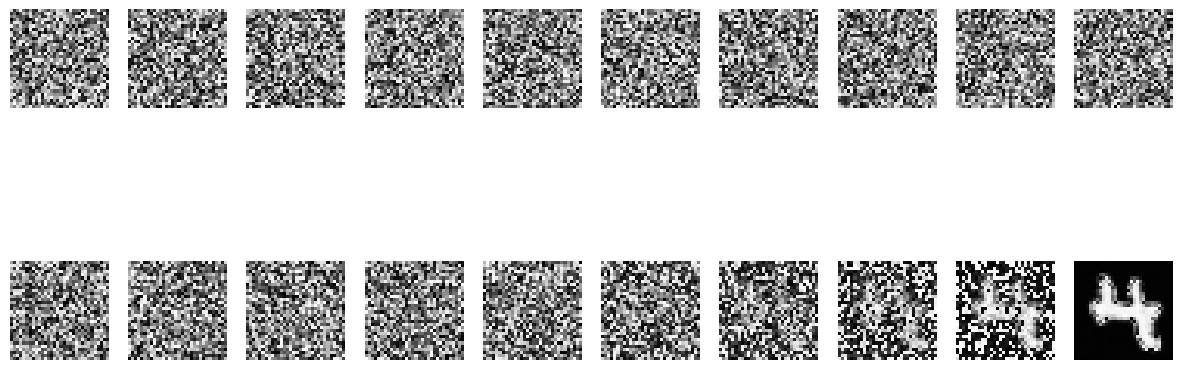

In [ ]:
test_image, images =sample(model,noise_scheduler,2)
plot_images(images)

> ### **Exercise:** Compare the results with the GAN model. Change the noise used in the Diffusion Networks and generate new samples.

[Schedulers](https://huggingface.co/docs/diffusers/v0.3.0/en/api/schedulers#diffusers.DDPMScheduler)

As we can see, the Difussion Model perform better than the GAN, this is probably because we only need to train one model besides the two that we have to trai in the GAN's. However, the Difussion Model has been trainning for 9 minutes and the GAN during only 2, so we also would take into account this difference in order to choose which of the options is better for a concret case.

In the code of above, we have changed the noise used in the Difussuion Network; Modified to uniform noise in range [-1, 1]. We are gonna retrain the model and generate new samples. In the image abovelooks like that change of the noise has effects on the final result, the last image that we have obtained has a lower quality than the previous one.

In [ ]:
def train_loop(
        config,
        model,
        noise_scheduler,
        optimizer,
        train_dataloader,
        lr_scheduler):

    accelerator = accelerate.Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps,
    )

    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )

    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader),
                            disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']

            # MODIFICATION: Using uniform noise distribution instead of Gaussian
            # noise = torch.randn(clean_images.shape).to(clean_images.device)
            noise = torch.rand(clean_images.shape).to(clean_images.device) * 2 - 1  # Uniform noise in range [-1, 1]

            batch_size = clean_images.shape[0]

            # Sample a set of random time steps for each image in mini-batch
            timesteps = torch.randint(
                0, noise_scheduler.num_train_timesteps, (batch_size,), device=clean_images.device)

            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps.cpu())

            with accelerator.accumulate(model):
                noise_pred = model(noisy_images, timesteps)["sample"]
                loss = torch.nn.functional.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()

            progress_bar.update(1)
            logs = {
                "loss": loss.detach().item(),
                "lr": lr_scheduler.get_last_lr()[0],
            }
            progress_bar.set_postfix(**logs)

    accelerator.unwrap_model(model)

In [ ]:
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

accelerate.notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

  0%|          | 0/625 [00:00<?, ?it/s]

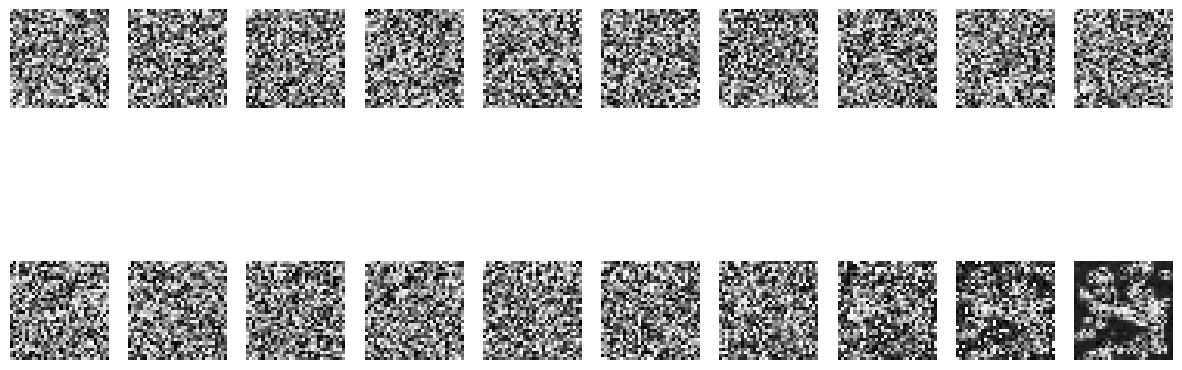

In [ ]:
test_image, images =sample(model,noise_scheduler,2)
plot_images(images)